# Entrega 4 - Redes Neuronales

### Grupo 9:
     - J. Gu       C.I 5.509.557-9
     - M. Nuñez    C.I 5.225.262-3
     - L. Pereira  C.I 5.268.309-4



## 1. Objetivo

El objetivo de esta tarea es implementar y evaluar distintos modelos basados en redes neuronales y regresión logística, compararlos entre sí y con los modelos realizados en laboratorios anteriores para sacar conclusiones sobre su desempeño. 

El éxito del aprendizaje se mide a través de los valores de accuracy, precisión, recall y f1. Analizaremos los valores de cada uno de los modelos generados y compararemos cual se desempeño mejor.


## 2. Diseño y experimentación

En esta sección, dado que el diseño de los modelos 1 a 4 que había que implementar venía dado por la letra, para dichos modelos solamente aclararemos las consideraciones que tuvimos. Con respecto al modelo 5 y las 3 alternativas planteadas si aclararemos los detalles del diseño.

Para la implementación de todos los modelos nos basamos fuertemente en el teórico dado en el curso y en la documentación de pytorch. En específico a la documentación brindad en este link: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [7]:
DATASET_FILE = 'lab4_dataset.csv'
dataset = pd.read_csv(DATASET_FILE, sep=",")
dataset = dataset.drop(columns=['time'])

print("Separando el conjunto de datos en conjunto de entrenamiento y conjunto de prueba...")
# Dividir el conjunto de datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_full, test = train_test_split(dataset, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento completo en conjunto de entrenamiento (90%) y validación (10%)
train, validation = train_test_split(train_full, test_size=0.1, random_state=42)

# Separar características (X) y etiquetas (y) para el conjunto de entrenamiento y validación
X_train = train.drop(columns=['cid'])  
y_train = train['cid']

X_val = validation.drop(columns=['cid'])
y_val = validation['cid']


Separando el conjunto de datos en conjunto de entrenamiento y conjunto de prueba...


### Modelo 1

In [8]:
print("Entrenando modelo de regresión logística...")

# Crear el modelo de regresión logística
model1 = LogisticRegression(max_iter=3000)

# Entrenar el modelo con el conjunto de entrenamiento
model1.fit(X_train, y_train)

# Predecir las etiquetas del conjunto de validación
y_pred = model1.predict(X_val)

# Calcular la accuracy en el conjunto de validación
accuracy = accuracy_score(y_val, y_pred)

print(f'Accuracy del modelo de regresión logística: {accuracy:.4f}')

Entrenando modelo de regresión logística...
Accuracy del modelo de regresión logística: 0.7733


/home/julio/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La regresión logística es un modelo lineal que se adapta bien a problemas de clasificación binaria. En este tipo de datasets, el modelo estima la probabilidad de que una instancia pertenezca a una clase determinada, utilizando una combinación lineal de las características. En este caso, la accuracy alcanzada por el modelo es de 0.7733, lo cual es un buen indicador de que el modelo está logrando clasificar correctamente el 77.33% de las instancias.

La precisión en términos generales, indica que el modelo tiene un buen desempeño clasificando correctamente las instancias del dataset. Sin embargo, es importante tener en cuenta que la accuracy por sí sola puede ser engañosa en casos de desbalance de clases. En datasets con muchas más instancias de una clase (como es el caso aquí con más instancias negativas), el modelo puede obtener una alta accuracy simplemente por predecir siempre la clase mayoritaria, sin necesariamente identificar bien las instancias de la clase minoritaria.

### Modelo 2

In [37]:
# Definir el modelo con una sola neurona lineal y dos salidas (para 2 clases)
class SimpleNN(nn.Module):
    def __init__(self, features):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(features, 2)  #features es el número de características

    def forward(self, x):
        return self.linear(x)

In [38]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct


In [39]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [40]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = SimpleNN(X_train_tensor.shape[1])

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.6027, Train Accuracy: 0.6959, Val Loss: 0.6081, Val Accuracy: 0.6977
Epoch [20/100], Loss: 0.5635, Train Accuracy: 0.7459, Val Loss: 0.5658, Val Accuracy: 0.7384
Epoch [30/100], Loss: 0.5475, Train Accuracy: 0.7739, Val Loss: 0.5409, Val Accuracy: 0.7500
Epoch [40/100], Loss: 0.5113, Train Accuracy: 0.7836, Val Loss: 0.5250, Val Accuracy: 0.7558
Epoch [50/100], Loss: 0.5101, Train Accuracy: 0.7882, Val Loss: 0.5140, Val Accuracy: 0.7500
Epoch [60/100], Loss: 0.4932, Train Accuracy: 0.7908, Val Loss: 0.5066, Val Accuracy: 0.7442
Epoch [70/100], Loss: 0.5028, Train Accuracy: 0.7947, Val Loss: 0.5011, Val Accuracy: 0.7442
Epoch [80/100], Loss: 0.4843, Train Accuracy: 0.7927, Val Loss: 0.4971, Val Accuracy: 0.7442
Epoch [90/100], Loss: 0.4868, Train Accuracy: 0.7934, Val Loss: 0.4943, Val Accuracy: 0.7442
Epoch [100/100], Loss: 0.4718, Train Accuracy: 0.7908, Val Loss: 0.4917, Val Accuracy: 0.7384


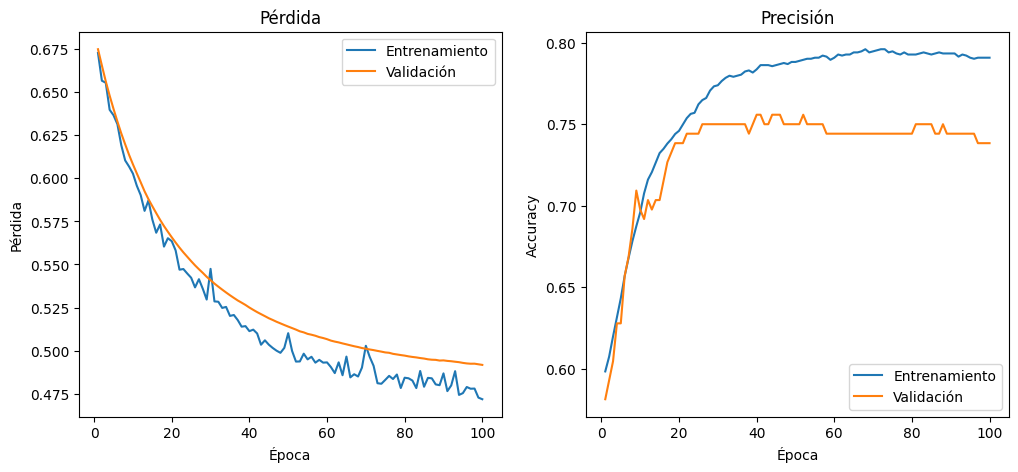

In [13]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

En este experimento, se entrenó una red neuronal con una sola capa lineal, utilizando la función de pérdida de entropía cruzada. Los resultados mostraron una convergencia estable tanto en la pérdida como en la accuracy, tanto para el conjunto de entrenamiento como para el conjunto de validación, a lo largo de las 100 épocas.

##### Observaciones:

- Pérdida: La pérdida disminuye consistentemente en ambos conjuntos, indicando que el modelo está aprendiendo de manera efectiva. Sin embargo, se observa que la curva de validación comienza a estabilizarse después de aproximadamente 40 épocas, lo que sugiere que el modelo alcanza su punto de convergencia relativamente temprano.
- Accuracy: La accuracy en el conjunto de validación alcanzó un máximo de 0.7558 alrededor de la época 40, y luego se mantuvo estable. Esto indica que el modelo no sigue mejorando significativamente en la segunda mitad del entrenamiento.

### Modelo 3

In [14]:
class SimpleSigmoidNN(nn.Module):
    def __init__(self, features):
        super(SimpleSigmoidNN, self).__init__()
        self.linear = nn.Linear(features, 1)  # Una neurona, una salida
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))  # Activación sigmoide

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Si pred contiene probabilidades, usamos 0.5 como umbral para clase binaria
        pred_class = (pred > 0.5).type(torch.float)  # Clase 1 si probabilidad > 0.5
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [16]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
            test_loss += loss_fn(pred, y).item()

            # Umbral de 0.5 para clasificación binaria
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [17]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)


dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = SimpleSigmoidNN(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.6555, Train Accuracy: 0.6322, Val Loss: 0.6976, Val Accuracy: 0.5698
Epoch [20/100], Loss: 0.6169, Train Accuracy: 0.6881, Val Loss: 0.6549, Val Accuracy: 0.6628
Epoch [30/100], Loss: 0.5871, Train Accuracy: 0.7271, Val Loss: 0.6233, Val Accuracy: 0.6860
Epoch [40/100], Loss: 0.5672, Train Accuracy: 0.7485, Val Loss: 0.5992, Val Accuracy: 0.7093
Epoch [50/100], Loss: 0.5441, Train Accuracy: 0.7615, Val Loss: 0.5810, Val Accuracy: 0.7209
Epoch [60/100], Loss: 0.5356, Train Accuracy: 0.7700, Val Loss: 0.5662, Val Accuracy: 0.7384
Epoch [70/100], Loss: 0.5256, Train Accuracy: 0.7706, Val Loss: 0.5545, Val Accuracy: 0.7500
Epoch [80/100], Loss: 0.5117, Train Accuracy: 0.7791, Val Loss: 0.5448, Val Accuracy: 0.7733
Epoch [90/100], Loss: 0.5107, Train Accuracy: 0.7810, Val Loss: 0.5369, Val Accuracy: 0.7674
Epoch [100/100], Loss: 0.4981, Train Accuracy: 0.7862, Val Loss: 0.5303, Val Accuracy: 0.7616


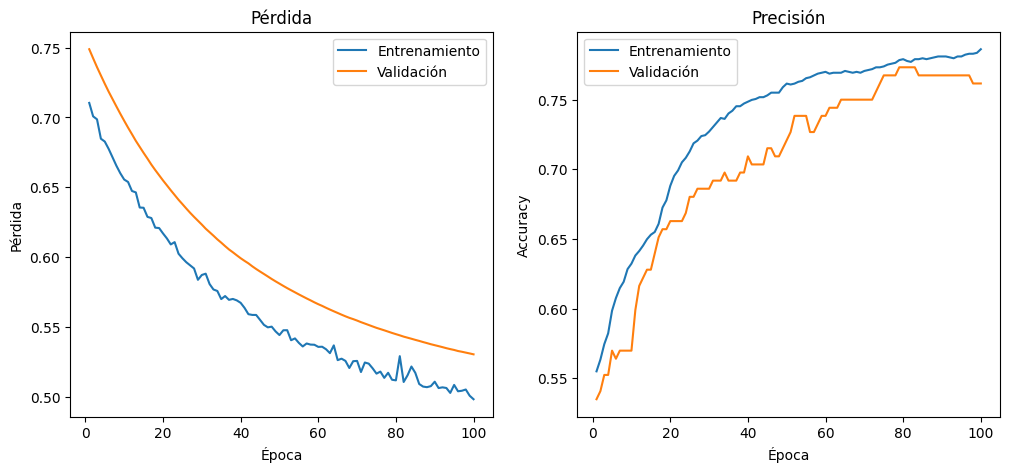

In [18]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Modelo 4

In [19]:
class SigmoidNNWithHiddenLayer(nn.Module):
    def __init__(self, features):
        super(SigmoidNNWithHiddenLayer, self).__init__()
        self.hidden = nn.Linear(features, 16)   # Capa oculta con 16 unidades
        self.output = nn.Linear(16, 2)          # Capa de salida con 2 neuronas (para las dos clases)
    
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = torch.softmax(self.output(x), dim=1) # Softmax para obtener probabilidades
        return x

In [20]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)  # La salida ya tiene forma (batch_size, 2)
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Obtener la clase predicha (índice de la mayor probabilidad)
        pred_class = pred.argmax(dim=1)  # Clase con la mayor probabilidad
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [21]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)  # La salida ya tiene forma (batch_size, 2)
            test_loss += loss_fn(pred, y).item()

            # Obtener la clase predicha (índice de la mayor probabilidad)
            pred_class = pred.argmax(dim=1)  # Clase con la mayor probabilidad
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [22]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
# Crear la red neuronal
model = SigmoidNNWithHiddenLayer(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

Epoch [10/100], Loss: 0.5523, Train Accuracy: 0.7570, Val Loss: 0.5691, Val Accuracy: 0.7326
Epoch [20/100], Loss: 0.5499, Train Accuracy: 0.7570, Val Loss: 0.5668, Val Accuracy: 0.7326
Epoch [30/100], Loss: 0.5525, Train Accuracy: 0.7570, Val Loss: 0.5631, Val Accuracy: 0.7326
Epoch [40/100], Loss: 0.5450, Train Accuracy: 0.7570, Val Loss: 0.5570, Val Accuracy: 0.7326
Epoch [50/100], Loss: 0.5377, Train Accuracy: 0.7648, Val Loss: 0.5500, Val Accuracy: 0.7442
Epoch [60/100], Loss: 0.5269, Train Accuracy: 0.7739, Val Loss: 0.5440, Val Accuracy: 0.7616
Epoch [70/100], Loss: 0.5265, Train Accuracy: 0.7804, Val Loss: 0.5412, Val Accuracy: 0.7500
Epoch [80/100], Loss: 0.5287, Train Accuracy: 0.7856, Val Loss: 0.5386, Val Accuracy: 0.7674
Epoch [90/100], Loss: 0.5178, Train Accuracy: 0.7908, Val Loss: 0.5365, Val Accuracy: 0.7616
Epoch [100/100], Loss: 0.5139, Train Accuracy: 0.7908, Val Loss: 0.5340, Val Accuracy: 0.7674


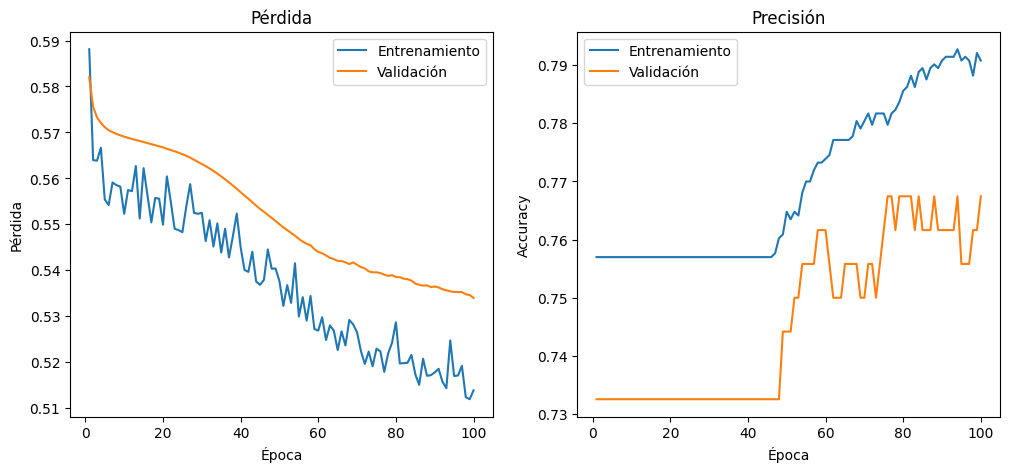

In [23]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Modelo 5.A

La primer arquitectura que planteamos para intentar mejorar los resultados previamente obtenidos fue una red neuronal simple.

Esta red está compuesta por:

- Una capa de entrada lineal, que recibe el número de atributos a utilizar como de entrada y las transforma en 16 neuronas.

- Una función de activación LeakyReLU que se aplica después de la capa de entrada para añadir no linealidad y permitir que la red aprenda patrones más complejos.

- Un Dropout con probabilidad 0.4 después de la capa de entrada, que desactiva el 40% de las neuronas en cada paso para reducir el riesgo de sobreajuste.

- Una capa oculta lineal que recibe las 16 neuronas de la capa de entrada y las reduce a 8 neuronas para continuar el proceso de aprendizaje.

- Otra función de activación LeakyReLU que se aplica después de la capa oculta para introducir una segunda no linealidad en el modelo.

- Un segundo Dropout de probabilidad 0.4, que vuelve a desactivar el 40% de las neuronas en la capa oculta para mejorar la generalización.

- Una capa de salida lineal, que recibe las 8 neuronas de la capa oculta y produce una única salida que representa la probabilidad de una clase en un problema de clasificación binaria.

Esta arquitectura permite que la red clasifique las entradas en una de dos clases posibles (binaria), aplicando la función de pérdida BCEWithLogitsLoss, que calcula la pérdida con una activación sigmoide para obtener probabilidades en la salida.
Esta red se utilizó con el optimizador SGD, que se basa en el descenso por gradiente y con un paso de 0.05 de tasa de aprendizaje. Este paso fue definido tras probar con distintos valores y ver que el mejor desempeño se dió en este caso.

In [24]:
class NeuronalNetworkV1(nn.Module):
    def __init__(self, features):
        super(NeuronalNetworkV1, self).__init__()
        self.input_layer = nn.Linear(features, 16)
        self.hidden_activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.4)

        # Añadir más capas ocultas
        self.hidden_layer1 = nn.Linear(16, 8)
        
        self.output_layer = nn.Linear(8, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.hidden_layer1(x)
        x = self.hidden_activation(x)
        x = self.dropout(x)

        x = self.output_layer(x)
        return x

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()  # Modo de entrenamiento
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
        loss = loss_fn(pred, y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular métricas
        train_loss += loss.item()

        # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
        pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
        # Si pred contiene probabilidades, usamos 0.5 como umbral para clase binaria
        pred_class = (pred > 0.5).type(torch.float)  # Clase 1 si probabilidad > 0.5
        correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [26]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # Modo de evaluación
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()  # Aplanar la salida para que sea un vector
            test_loss += loss_fn(pred, y).item()

            # Convertimos los logits en probabilidades aplicando Sigmoid para la evaluación
            pred = torch.sigmoid(pred)  # Aplica sigmoid para obtener las probabilidades
            # Umbral de 0.5 para clasificación binaria
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    # Promedio de pérdida y precisión
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

In [27]:
# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)


dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Crear la red neuronal
model = NeuronalNetworkV1(X_train_tensor.shape[1])

# Definir la función de pérdida (entropía cruzada binaria) y el optimizador (SGD)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

Epoch [10/100], Loss: 0.5300, Train Accuracy: 0.7576, Val Loss: 0.5245, Val Accuracy: 0.7326
Epoch [20/100], Loss: 0.5100, Train Accuracy: 0.7713, Val Loss: 0.5027, Val Accuracy: 0.7500
Epoch [30/100], Loss: 0.4888, Train Accuracy: 0.7687, Val Loss: 0.4920, Val Accuracy: 0.7500
Epoch [40/100], Loss: 0.5047, Train Accuracy: 0.7739, Val Loss: 0.4919, Val Accuracy: 0.7616
Epoch [50/100], Loss: 0.4764, Train Accuracy: 0.7765, Val Loss: 0.4945, Val Accuracy: 0.7616
Epoch [60/100], Loss: 0.4736, Train Accuracy: 0.7771, Val Loss: 0.4975, Val Accuracy: 0.7500
Epoch [70/100], Loss: 0.4689, Train Accuracy: 0.7771, Val Loss: 0.4932, Val Accuracy: 0.7558
Epoch [80/100], Loss: 0.4827, Train Accuracy: 0.7784, Val Loss: 0.4862, Val Accuracy: 0.7733
Epoch [90/100], Loss: 0.4651, Train Accuracy: 0.7732, Val Loss: 0.4903, Val Accuracy: 0.7616
Epoch [100/100], Loss: 0.4561, Train Accuracy: 0.7914, Val Loss: 0.4944, Val Accuracy: 0.7849


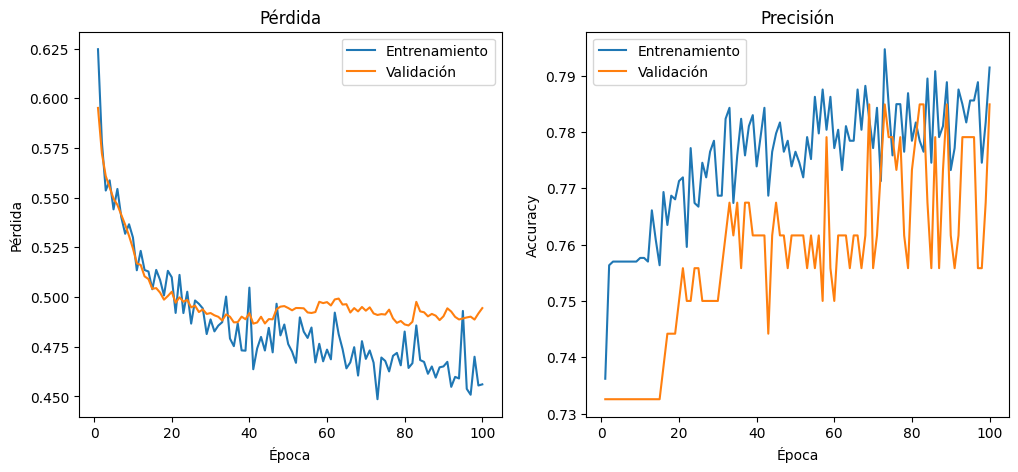

In [28]:
# Entrenamiento
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Ejecutar el ciclo de entrenamiento
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Ejecutar el ciclo de validación
    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Graficar las pérdidas y accuracies
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfico de la accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Modelo 5.B

La segunda arquitectura que planteamos para intentar mejorar los resultados previamente obtenidos fue una red neuronal simple. Esta red está compuesta por:

- Capa de entrada: una capa lineal que recibe el número de atributos de entrada y los transforma en 8 neuronas. Esta capa inicial es seguida de una normalización BatchNorm1d para estandarizar la activación de las neuronas en la red y acelerar el proceso de entrenamiento.

- Función de activación: se utiliza la función de activación ReLU, fue elegida en este modelo debido a su simplicidad y rendimiento eficiente en la mayoría de los problemas de clasificación. ReLU es particularmente eficaz cuando se espera que los valores de activación negativos no contribuyan significativamente al aprendizaje, lo que permite que las neuronas se apaguen cuando reciben activaciones negativas. Esto puede acelerar el entrenamiento, ya que reduce el riesgo de que la red se vea afectada por valores pequeños que se propagan a lo largo de las capas.. Esta función se aplica después de la capa de entrada y de las capas ocultas.

- Capa oculta: en lugar de dos capas ocultas, esta arquitectura utiliza solo una capa oculta lineal que reduce las 8 neuronas a 4. Esta capa también está seguida de una normalización BatchNorm1d para mantener las activaciones de la red en una escala adecuada.

- Dropout: se utiliza un Dropout con una probabilidad de 0.4 después de la capa oculta. El Dropout desactiva el 32.5% de las neuronas durante el entrenamiento, lo que ayuda a mejorar la generalización y reduce el riesgo de sobreajuste.

- Capa de salida: una capa lineal que recibe las 4 neuronas de la capa oculta y produce una única salida, representando la probabilidad de la clase en un problema de clasificación binaria.

- Esta arquitectura permite que la red neuronal clasifique las entradas en una de dos clases posibles (problema de clasificación binaria). La función de pérdida utilizada es BCEWithLogitsLoss, que combina la función de pérdida de entropía cruzada con una activación sigmoide interna para obtener probabilidades en la salida.

- El optimizador utilizado es Adam, conocido por su eficiencia en problemas de optimización, con una tasa de aprendizaje de 0.001. Este valor fue elegido tras probar distintas tasas de aprendizaje, observando un mejor rendimiento con esta configuración.

La red fue entrenada utilizando un ciclo de entrenamiento definido por la función train_loop, que maneja el entrenamiento batch por batch. Durante cada batch, se calcula la pérdida y se ajustan los pesos de la red utilizando el optimizador Adam. A diferencia del descenso por gradiente estándar, que utiliza una única tasa de aprendizaje para todos los parámetros, Adam adapta la tasa de aprendizaje de manera individual para cada parámetro, basándose en el promedio móvil de los gradientes y el promedio móvil de los cuadrados de los gradientes anteriores. Esto permite que Adam mantenga un equilibrio entre la eficiencia de convergencia y la estabilidad, siendo especialmente efectivo en problemas con datos ruidosos o características escasas.

In [29]:
class NeuronalNetworkV2(nn.Module):
    def __init__(self, features):
        super(NeuronalNetworkV2, self).__init__()
        # Capa de entrada
        self.input_layer = nn.Linear(features, 8)
        self.hidden_activation = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(8)
        
        # Capa oculta (una en lugar de dos)
        self.hidden_layer = nn.Linear(8, 4)
        self.batch_norm2 = nn.BatchNorm1d(4)
        
        # Capa de salida
        self.output_layer = nn.Linear(4, 1)
        self.dropout = nn.Dropout(p=0.4)  # 50% de dropout

    def forward(self, x):
        x = self.input_layer(x)
        x = self.batch_norm1(x)
        x = self.hidden_activation(x)
        
        x = self.hidden_layer(x)
        x = self.batch_norm2(x)
        x = self.hidden_activation(x)
        
        x = self.dropout(x)

        x = self.output_layer(x)
        return x

In [30]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = torch.sigmoid(pred)
        pred_class = (pred > 0.5).type(torch.float)
        correct += (pred_class == y).type(torch.float).sum().item()

    train_loss /= len(dataloader)
    correct /= size
    return train_loss, correct

In [31]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze()
            test_loss += loss_fn(pred, y).item()

            pred = torch.sigmoid(pred)
            pred_class = (pred > 0.5).type(torch.float)
            correct += (pred_class == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    return test_loss, correct


In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

model = NeuronalNetworkV2(X_train_tensor.shape[1])

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.5671, Train Accuracy: 0.6173, Val Loss: 0.5555, Val Accuracy: 0.7384
Epoch [20/100], Loss: 0.5128, Train Accuracy: 0.7888, Val Loss: 0.5042, Val Accuracy: 0.7558
Epoch [30/100], Loss: 0.5108, Train Accuracy: 0.7888, Val Loss: 0.4997, Val Accuracy: 0.7558
Epoch [40/100], Loss: 0.4788, Train Accuracy: 0.7810, Val Loss: 0.4860, Val Accuracy: 0.7674
Epoch [50/100], Loss: 0.4811, Train Accuracy: 0.7810, Val Loss: 0.4799, Val Accuracy: 0.7733
Epoch [60/100], Loss: 0.4707, Train Accuracy: 0.7947, Val Loss: 0.4746, Val Accuracy: 0.7733
Epoch [70/100], Loss: 0.4607, Train Accuracy: 0.7979, Val Loss: 0.4778, Val Accuracy: 0.8023
Epoch [80/100], Loss: 0.4564, Train Accuracy: 0.7895, Val Loss: 0.4760, Val Accuracy: 0.7907
Epoch [90/100], Loss: 0.4591, Train Accuracy: 0.7921, Val Loss: 0.4749, Val Accuracy: 0.7907
Epoch [100/100], Loss: 0.4632, Train Accuracy: 0.7862, Val Loss: 0.4848, Val Accuracy: 0.7791


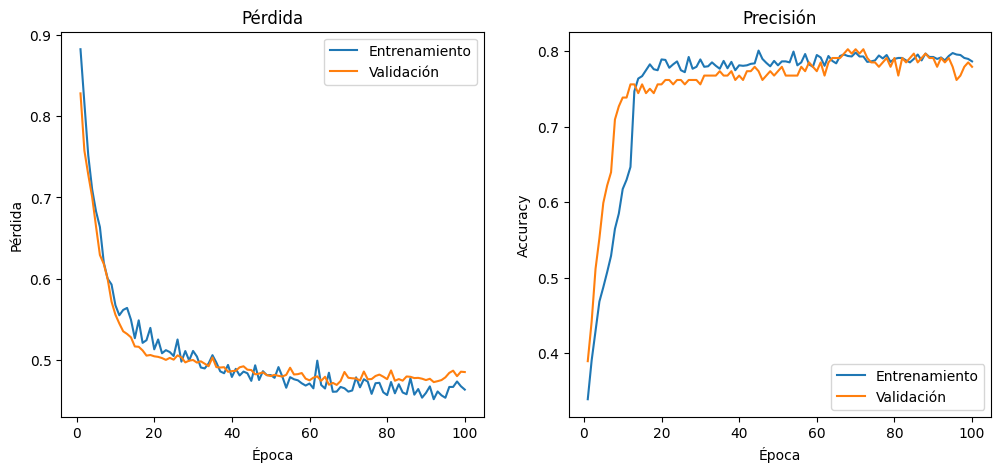

In [33]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_loop(dataloader_train, model, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    val_loss, val_acc = test_loop(dataloader_val, model, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Entrenamiento')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Entrenamiento')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##### Observaciones:

- Pérdida:
 A lo largo de las 100 épocas, la pérdida disminuye de manera constante, lo que sugiere que el modelo está aprendiendo y ajustando correctamente sus parámetros. Sin embargo, a partir de la época 60, la pérdida se estabiliza tanto para el conjunto de entrenamiento como para el conjunto de validación, lo que indica que el modelo ha alcanzado su capacidad máxima de aprendizaje. En general, el comportamiento de la pérdida muestra que no hay signos de sobreajuste evidente, ya que ambas curvas de pérdida (entrenamiento y validación) siguen trayectorias similares.

- Accuracy:
 En la época 10, la accuracy en el conjunto de validación alcanzó el 73.84%, y continuó mejorando hasta alcanzar un valor máximo de 80.23% en la época 70. Después de este punto, la accuracy se mantiene relativamente estable, mostrando un buen rendimiento general del modelo.
La pequeña diferencia entre la accuracy de entrenamiento y la de validación sugiere que el modelo tiene una buena capacidad de generalización, es decir, es capaz de predecir correctamente en datos no vistos.

- Conclusiones:

    Si bien la accuracy no sigue mejorando después de las primeras 60-70 épocas, la estabilidad del modelo indica que ha aprendido patrones importantes en los datos sin sobreajustar.

    Es posible que ajustando la tasa de aprendizaje o implementando técnicas de regularización adicionales, como una tasa de Dropout más alta o early stopping, se pueda mejorar aún más la performance.

## 3. Experimentación

### Modelo 1

/home/julio/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


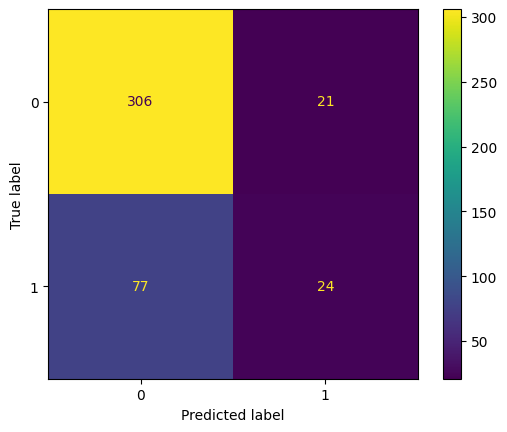

In [34]:
# Entrenamiento y predicción en el conjunto de prueba
model1 = LogisticRegression(max_iter=3000)
y_train_full = train_full['cid']
x_train_full = train_full.drop(columns=['cid'])
x_test = test.drop(columns=['cid'])
y_test = test['cid']
model1.fit(x_train_full, y_train_full)

# Predecir las etiquetas del conjunto de prueba
y_test_pred = model1.predict(x_test)

# Calcular métricas en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)




#### Aquí mostraremos las métricas obtenidas en el conjunto de prueba: accuracy, precision, recall y f1-score

In [35]:
print(f'Accuracy del modelo de regresión logística (prueba): {accuracy_test:.4f}')
print(f'Precision del modelo de regresión logística (prueba): {precision_test:.4f}')
print(f'Recall del modelo de regresión logística (prueba): {recall_test:.4f}')
print(f'F1 del modelo de regresión logística (prueba): {f1_test:.4f}')

Accuracy del modelo de regresión logística (prueba): 0.7710
Precision del modelo de regresión logística (prueba): 0.5333
Recall del modelo de regresión logística (prueba): 0.2376
F1 del modelo de regresión logística (prueba): 0.3288


- La precision de 0.5333 sugiere que, de las predicciones positivas, alrededor del 53% son correctas.
- El recall es bajo, con 0.2376, lo que significa que solo un 23% de las verdaderas instancias positivas están siendo identificadas correctamente por el modelo.
- El f1-score de 0.3288 refleja el balance entre la precisión y el recall. Esto indica que el modelo tiene problemas para identificar correctamente las instancias positivas.

#### Matriz de confusión

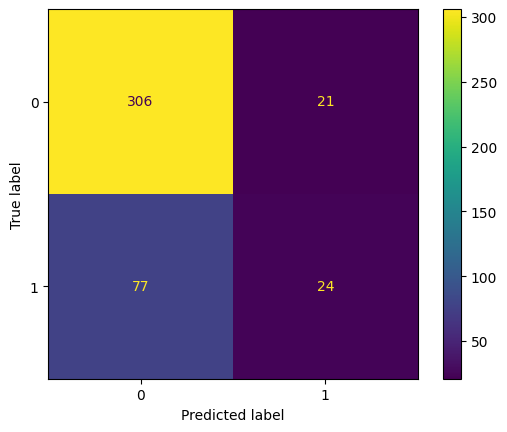

In [36]:
cm = confusion_matrix (y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

- El número de verdaderos negativos (306) es significativamente mayor que el de verdaderos positivos (24). Esto muestra que el modelo tiene un buen desempeño en la predicción de las clases mayoritarias (negativas).
- El modelo comete muchos errores al predecir instancias positivas, como lo muestra el número alto de falsos negativos (77).

## 4. Conclusión

Una breve conclusión del trabajo realizado. Por ejemplo: 
- ¿cuándo se dieron los mejores resultados del jugador?
- ¿encuentra alguna relación con los parámetros / oponentes/ atributos elegidos?
- ¿cómo mejoraría los resultados?